In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the dataset
df = pd.read_csv("./Month_Value_1.csv")

# Display the first few rows
print("Dataset Preview:")
df.head()

Dataset Preview:


,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [3]:
# Convert 'Period' to datetime and set as index
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df = df.set_index('Period')

# Drop NaN values for analysis
df = df.dropna()

In [4]:
ts_df = df['Sales_quantity']

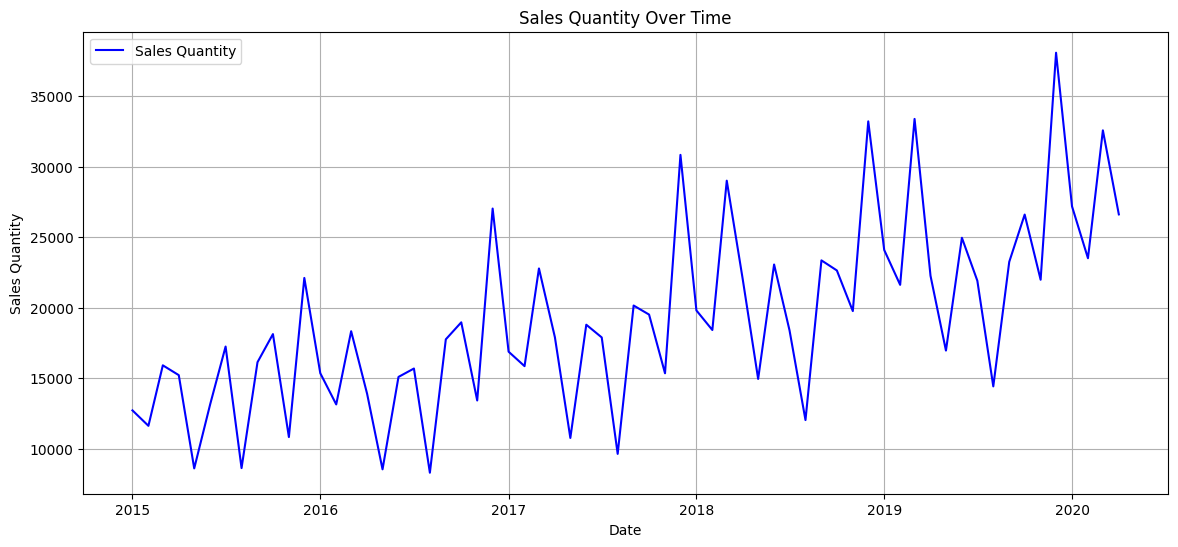

In [5]:
# Visualize the Revenue time series
plt.figure(figsize=(14, 6))
plt.plot(ts_df, label='Sales Quantity', color='blue')
plt.title('Sales Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid()

In [7]:
result = adfuller(ts_df)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary. Differencing is required.")

ADF Statistic: 1.157056206094537
p-value: 0.9956753282590142
The time series is non-stationary. Differencing is required.


In [8]:
df_diff = ts_df.diff().dropna()
result = adfuller(df_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -9.02300082504805
p-value: 5.7081705061833116e-15


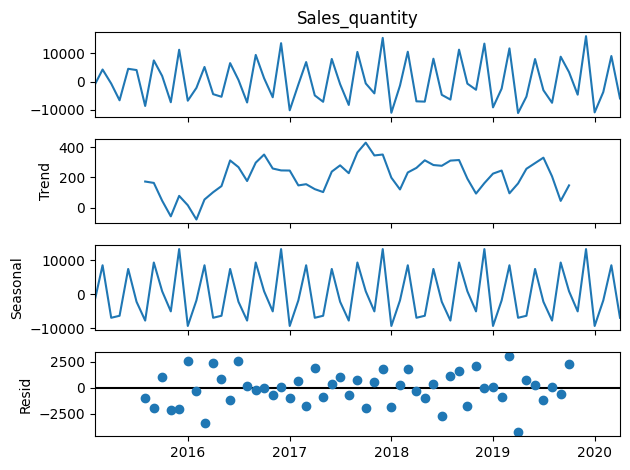

In [9]:
decomposed = seasonal_decompose(df_diff, model='additive')
decomposed.plot()
plt.show()

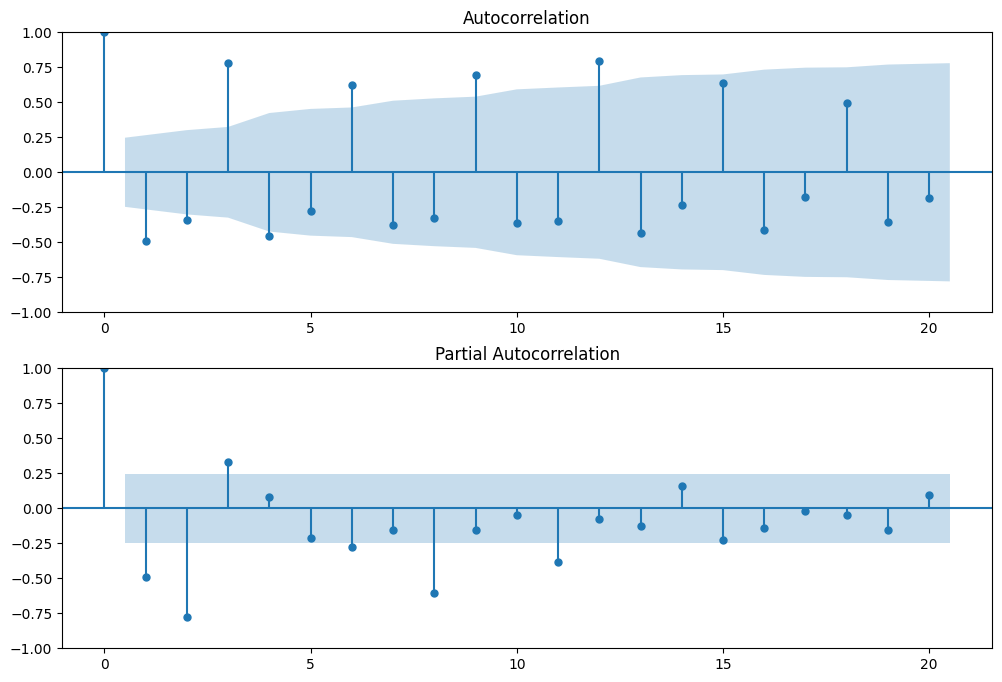

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=20, ax=ax[0])
plot_pacf(df_diff, lags=20, ax=ax[1])
plt.show()

In [17]:
model = ARIMA(ts_df, order=(4, 1, 3), freq='MS')
model_fit = model.fit()

c:\Users\Raunak\Projects\Python\practicals\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Raunak\Projects\Python\practicals\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Raunak\Projects\Python\practicals\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Raunak\Projects\Python\practicals\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Sales_quantity   No. Observations:                   64
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -605.806
Date:                Sun, 20 Apr 2025   AIC                           1227.612
Time:                        11:45:15   BIC                           1244.757
Sample:                    01-01-2015   HQIC                          1234.355
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2044      0.172     -1.191      0.233      -0.541       0.132
ar.L2         -0.2438      0.179     -1.359      0.174      -0.595       0.108
ar.L3          0.7142      0.198      3.608      0.000       0.326       1.102
ar.L4         -0.0400      0.145     -0.276      0.783      -0.325       0.245
ma.L1         -0.2033      0.115     -1.775      0.076      -0.428       0.021
ma.L2          0.3252      0.147      2.211      0.027       0.037       0.613
ma.L3         -0.8946      0.242     -3.698      0.000      -1.369      -0.420
sigma2      8.938e+06   3.54e-08   2.52e+14      0.000    8.94e+06    8.94e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.69   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.19   Prob(JB):                         0.35
Heteroskedasticity (H):               0.95   Skew:                             0.30
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  9e+29. Standard errors may be unstable.
"""

In [19]:
# Forecast the next 12 months
forecast = model_fit.forecast(steps=12)

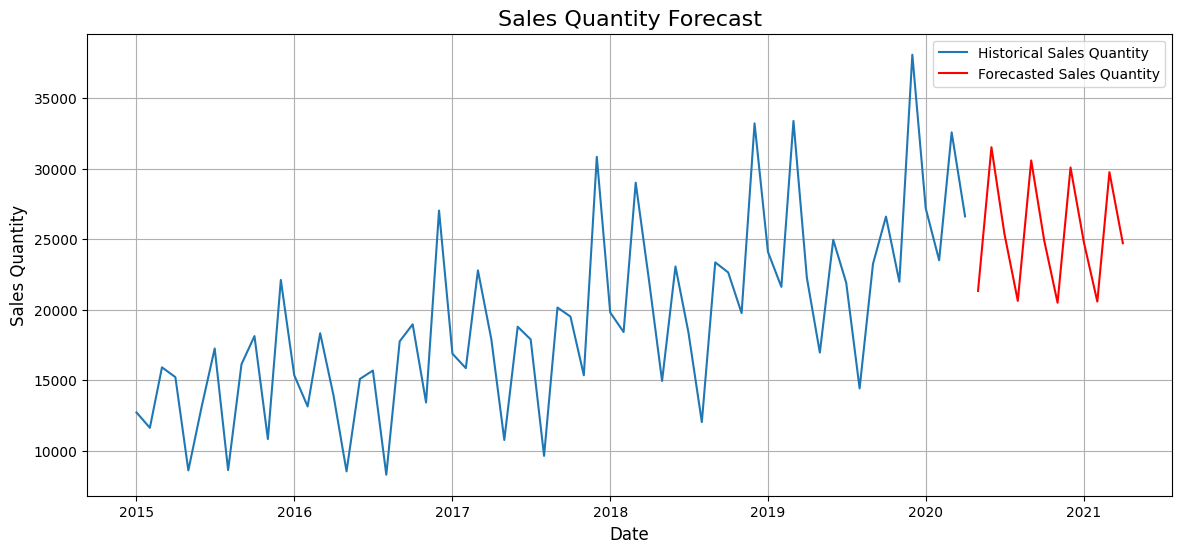

In [21]:
# Plot the predictions
plt.figure(figsize=(14, 6))
plt.plot(ts_df, label='Historical Sales Quantity')
plt.plot(forecast, label='Forecasted Sales Quantity', color='red')
plt.title('Sales Quantity Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()